In [21]:
import os
import argparse
import numpy as np
from tqdm import tqdm
from typing import Any

from dataloader import load_data
from RotNet import rotnet_constructor
from PredNet import prednet_constructor

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax import traverse_util
from flax.core.frozen_dict import freeze
from flax.training import train_state, checkpoints


import optax

In [2]:
# Define cifar10 image shape
CIFAR10_INPUT_SHAPE = (1, 32, 32, 3)

class TrainState(train_state.TrainState):
    batch_stats: Any

In [8]:
# Define cifar10 image shape
CIFAR10_INPUT_SHAPE = (1, 32, 32, 3)

class TrainState(train_state.TrainState):
    batch_stats: Any

def cross_entropy_loss_(logits, labels, num_classes=10):
    """
    Define loss: https://flax.readthedocs.io/en/latest/getting_started.html#define-loss
    """
    labels_onehot = jax.nn.one_hot(labels, num_classes=num_classes)
    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()
cross_entropy_loss = jax.jit(cross_entropy_loss_, static_argnums=2)

def compute_metrics_(logits, labels, num_classes):
    """
    Metric computation: https://flax.readthedocs.io/en/latest/getting_started.html#metric-computation
    """
    loss = cross_entropy_loss(logits=logits, labels=labels, num_classes=num_classes)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {"loss": loss, "accuracy": accuracy}
    return metrics
compute_metrics = jax.jit(compute_metrics_, static_argnums=2)

def create_train_state(rng, model, learning_rate, momentum):
    """
    Create train state: https://flax.readthedocs.io/en/latest/getting_started.html#create-train-state
    """
    variables = model.init(rng, jnp.ones(CIFAR10_INPUT_SHAPE, dtype=model.dtype), train=False)
    params, batch_stats = variables["params"], variables["batch_stats"]
    tx = optax.sgd(learning_rate, momentum)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=tx, batch_stats=batch_stats)
    return state, variables

def train_batch_(state, images, labels, num_classes=10):
    """
    Training step: https://flax.readthedocs.io/en/latest/getting_started.html#training-step
    """
    def loss_fn(params):
        logits, updates = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats}, images, mutable=["batch_stats"], train=True
        )
        loss = cross_entropy_loss(logits=logits, labels=labels, num_classes=num_classes)
        return loss, (logits, updates)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, (logits, updates)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates["batch_stats"])
    metrics = compute_metrics(logits=logits, labels=labels, num_classes=num_classes)
    return state, metrics
train_batch = jax.jit(train_batch_, static_argnums=3)

def train_epoch(state, dataloader, num_classes=10):
    """
    Train function: https://flax.readthedocs.io/en/latest/getting_started.html#train-function
    """
    batch_metrics = []
    for images, labels in dataloader:
        state, metrics = train_batch(state, images, labels, num_classes=num_classes)
        batch_metrics.append(metrics)
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]
    }
    return state, epoch_metrics_np

def eval_batch_(state, images, labels, num_classes=10):
    """
    Evaluation step: https://flax.readthedocs.io/en/latest/getting_started.html#evaluation-step
    """
    logits = state.apply_fn(
        {"params": state.params, "batch_stats": state.batch_stats}, images, mutable=False, train=False
    )
    return compute_metrics(logits=logits, labels=labels, num_classes=num_classes)
eval_batch = jax.jit(eval_batch_, static_argnums=3)

def eval_model(state, dataloader, num_classes=10):
    """
    Eval function: https://flax.readthedocs.io/en/latest/getting_started.html#eval-function
    """
    batch_metrics = []
    for images, labels in dataloader:
        metrics = eval_batch(state, images, labels, num_classes=num_classes)
        batch_metrics.append(metrics)
    batch_metrics_np = jax.device_get(batch_metrics)
    validation_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]
    }
    return validation_metrics_np["loss"], validation_metrics_np["accuracy"]

def extract_submodule(model):
    feature_extractor = model.features.clone()
    variables = model.features.variables
    return feature_extractor, variables

In [7]:
def create_train_state(rng, model, learning_rate, momentum):
    """
    Create train state: https://flax.readthedocs.io/en/latest/getting_started.html#create-train-state
    """
    variables = model.init(rng, jnp.ones(CIFAR10_INPUT_SHAPE, dtype=model.dtype), train=False)
    params, batch_stats = variables["params"], variables["batch_stats"]
    tx = optax.sgd(learning_rate, momentum)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=tx, batch_stats=batch_stats)
    return state, variables


Define your parameters here:

In [24]:
class Args:
    def __getitem__(self, key):
        return getattr(self, key)
    
    def __setitem__(self, key, val):
        setattr(self, key, val)
        
    def __contains__(self, key):
        return hasattr(self, key)
    
    # Define What RotNet architecture to use. 
    rotnet_arch : str = "rotnet3_feat3" #@param["rotnet3_feat3"] 
    # Define What PredNet architecture to use. 
    prednet_arch: str = "prednet3" #@param["rotnet3_feat3"]
    # Define Directory to Save RotNet Checkpoints"
    rotnet_ckpt_dir: str = "./ckpts/rotnet" #@param["rotnet3_feat3"]
    # Define Directory to Save PredNet Checkpoints
    prednet_ckpt_dir: str = "./ckpts/prednet" #@param["rotnet3_feat3"]
    # Continue to Train RotNet from rotnet_ckpt_epoch
    rotnet_ckpt_epoch: int = 0 #@param {type: "integer"}
    # Continue to train PredNet from prednet_ckpt_epoch
    prednet_ckpt_epoch: int = 0 #@param {type: "integer"}
    # Train RotNet for rotnet_epochs in Total
    rotnet_epochs: int = 10 #@param {type: "integer"}
    # Train PredNet for prednet_epochs in Total
    prednet_epochs: int = 10 #@param {type: "integer"}
    # Disable Gradient Flow in RotNet if Set to True
    no_grad: bool = True #@param {type: "boolean"}
    # Batch Size Per Process"
    batch_size: int = 128 #@param {type: "integer"}
    # Number of Data Loading Workers
    workers: int = 4 #@param {type: "integer"}
    # Learning Rate of the Optimizer
    lr: float = 1e-3 #@param {type: "float"}
    # Momentum of the Optimizer
    momentum: float = 0.9 #@param {type: "float"}
    # Print Model and Params Info
    verbose: bool = False #@param {type: "boolean"}
    
args = Args()

Preprocessing before training:

In [9]:
# ---------------------- Generate JAX Random Number Key ---------------------- #
rng = jax.random.PRNGKey(0)
print("Random Key Generated")

# -------------------------- Create the RotNet Model ------------------------- #
# Define network: https://flax.readthedocs.io/en/latest/getting_started.html#define-network
rotnet_model = rotnet_constructor(args.rotnet_arch)
print("Network Defined")
if args.verbose:
    print(nn.tabulate(rotnet_model, rng)(jnp.ones(CIFAR10_INPUT_SHAPE), False))

# ------------------------- Load the CIFAR10 Dataset ------------------------- #
# Loading data: https://flax.readthedocs.io/en/latest/getting_started.html#loading-data
# NOTE: Choose batch_size and workers based on system specs.
# NOTE: This dataloader requires pytorch to load the datset for convenience.
loaders = load_data(batch_size=args.batch_size, workers=args.workers)
train_loader, validation_loader, test_loader, rot_train_loader, rot_validation_loader, rot_test_loader = loaders
print("Data Loaded")

# --- Create the Train State Abstraction (see documentation in link below) --- #
# Create train state: https://flax.readthedocs.io/en/latest/getting_started.html#create-train-state
rotnet_state, rotnet_variables = create_train_state(rng, rotnet_model, args.lr, args.momentum)
print("Train State Created")

# ----------------- Specify the Directory to Save Checkpoints ---------------- #
rotnet_ckpt_dir = args.rotnet_ckpt_dir
if not os.path.exists(rotnet_ckpt_dir):
    os.makedirs(rotnet_ckpt_dir)
    print("RotNet Checkpoint Directory Created")
else:
    print("RotNet Checkpoint Directory Found")

Random Key Generated
Network Defined
Files already downloaded and verified
Files already downloaded and verified
Data Loaded
Train State Created
RotNet Checkpoint Directory Created


Train a RotNet:

In [10]:
# -------------------- Load Existing Checkpoint of RotNet -------------------- #
if args.rotnet_ckpt_epoch > 0:
    rotnet_state = checkpoints.restore_checkpoint(
        ckpt_dir=rotnet_ckpt_dir, target=rotnet_state, step=args.rotnet_ckpt_epoch
    )
    print("RotNet Checkpoint Loaded")

# ----------------------------- Train the RotNet ----------------------------- #
print("Starting RotNet Training Loop")
for epoch in tqdm(range(args.rotnet_ckpt_epoch + 1, args.rotnet_epochs + 1)):
    # ------------------------------- Training Step ------------------------------ #
    # Training step: https://flax.readthedocs.io/en/latest/getting_started.html#training-step
    rotnet_state, train_epoch_metrics = train_epoch(
        rotnet_state, rot_train_loader, num_classes=4
    )

    # Print training metrics every epoch
    print(
        f"train epoch: {epoch}, \
        loss: {train_epoch_metrics['loss']:.4f}, \
        accuracy:{train_epoch_metrics['accuracy']*100:.2f}%"
    )

    # ------------------------------ Evaluation Step ----------------------------- #
    # Evaluation step: https://flax.readthedocs.io/en/latest/getting_started.html#evaluation-step
    validation_loss, validation_accuracy = eval_model(rotnet_state, rot_validation_loader, num_classes=4)

    # Print validation metrics every epoch
    print(f"validation loss: {validation_loss:.4f}, validation accuracy:{validation_accuracy*100:.2f}%")

    # ---------------------------- Saving Checkpoints ---------------------------- #
    # ---- https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html --- #
    checkpoints.save_checkpoint(
        ckpt_dir=rotnet_ckpt_dir, target=rotnet_state, step=epoch, overwrite=True, keep=args.rotnet_epochs
    )

    # Print test metrics every nth epoch
    if epoch % 5 == 0:
        _, test_accuracy = eval_model(rotnet_state, rot_test_loader, num_classes=4)
        print("====================")
        print(f"test_accuracy: {test_accuracy*100:.2f}%")
        print("====================")

Starting RotNet Training Loop


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1,         loss: 1.1237,         accuracy:57.64%


 10%|█         | 1/10 [00:29<04:22, 29.19s/it]

validation loss: 1.0353, validation accuracy:59.40%
train epoch: 2,         loss: 0.8295,         accuracy:67.36%


 20%|██        | 2/10 [00:54<03:35, 26.93s/it]

validation loss: 0.8265, validation accuracy:67.37%
train epoch: 3,         loss: 0.7262,         accuracy:71.63%


 30%|███       | 3/10 [01:20<03:03, 26.28s/it]

validation loss: 0.8101, validation accuracy:68.43%
train epoch: 4,         loss: 0.6550,         accuracy:74.61%


 40%|████      | 4/10 [01:45<02:35, 25.97s/it]

validation loss: 0.7824, validation accuracy:69.99%
train epoch: 5,         loss: 0.6072,         accuracy:76.56%
validation loss: 0.7758, validation accuracy:70.22%


 50%|█████     | 5/10 [02:15<02:17, 27.59s/it]

test_accuracy: 70.03%
train epoch: 6,         loss: 0.5616,         accuracy:78.65%


 60%|██████    | 6/10 [02:41<01:47, 26.85s/it]

validation loss: 0.7286, validation accuracy:72.24%
train epoch: 7,         loss: 0.5257,         accuracy:80.16%


 70%|███████   | 7/10 [03:06<01:19, 26.43s/it]

validation loss: 0.7528, validation accuracy:71.70%
train epoch: 8,         loss: 0.4940,         accuracy:81.44%


 80%|████████  | 8/10 [03:32<00:52, 26.16s/it]

validation loss: 0.7467, validation accuracy:72.29%
train epoch: 9,         loss: 0.4619,         accuracy:82.65%


 90%|█████████ | 9/10 [03:58<00:25, 25.94s/it]

validation loss: 0.7973, validation accuracy:71.12%
train epoch: 10,         loss: 0.4327,         accuracy:83.83%
validation loss: 0.8096, validation accuracy:70.88%


100%|██████████| 10/10 [04:28<00:00, 26.80s/it]

test_accuracy: 70.81%


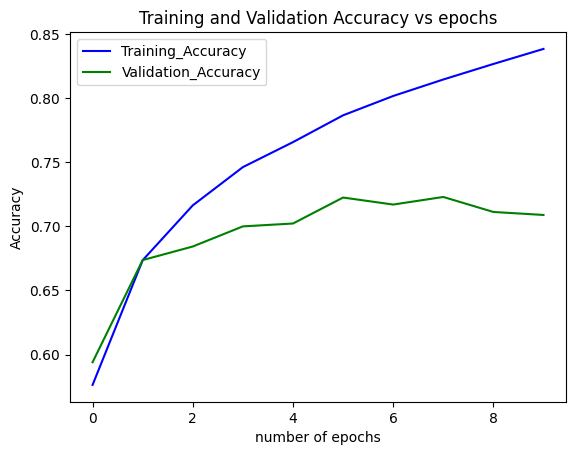

In [11]:
plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(valid_acc)), valid_acc, color = 'green')
plt.title("Training and Validation Accuracy vs epochs")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.legend(["Training_Accuracy", "Validation_Accuracy"])


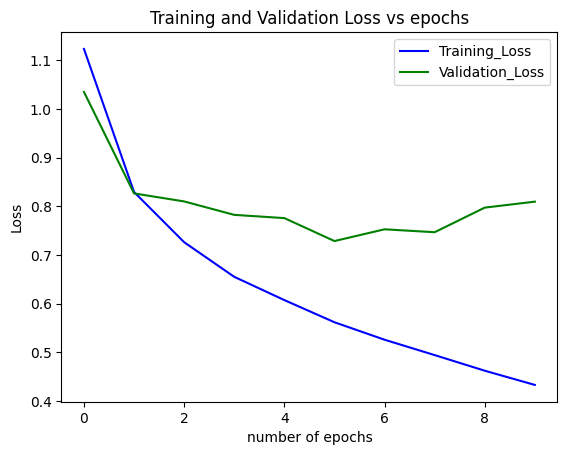

In [12]:
plt.plot(np.arange(len(train_loss)), train_loss, color = 'blue')
plt.plot(np.arange(len(valid_loss)), valid_loss, color = 'green')
plt.title("Training and Validation Loss vs epochs")
plt.xlabel("number of epochs")
plt.ylabel("Loss")
plt.legend(["Training_Loss", "Validation_Loss"])

Preprocessing for training PredNet:

In [14]:
# ---- https://flax.readthedocs.io/en/latest/guides/transfer_learning.html --- #
# ----------------------------- Extract Backbone ----------------------------- #
backbone_model, backbone_model_variables = nn.apply(extract_submodule, rotnet_model)(rotnet_variables)

# ------------------------- Create the Prednet Model ------------------------- #
prednet_model = prednet_constructor(args.prednet_arch, backbone_model)

# ----------------------- Extract Variables and Params ----------------------- #
prednet_variables   = prednet_model.init(rng, jnp.ones(CIFAR10_INPUT_SHAPE), train=False)
prednet_params      = prednet_variables['params']
prednet_batch_stats = prednet_variables['batch_stats']

# --------------------- Transfer the Backbone Parameters --------------------- #
prednet_params              = prednet_params.unfreeze()
prednet_params['backbone']  = backbone_model_variables['params']
prednet_params              = freeze(prednet_params)

if not args.no_grad:
    prednet_batch_stats              = prednet_batch_stats.unfreeze()
    prednet_batch_stats['backbone']  = backbone_model_variables['batch_stats']
    prednet_batch_stats              = freeze(prednet_batch_stats)

# -------------------------- Define How to Backprop -------------------------- #
if args.no_grad:
    partition_optimizers = {'trainable': optax.sgd(args.lr, args.momentum), 'frozen': optax.set_to_zero()}
    prednet_param_partitions = freeze(traverse_util.path_aware_map(
        lambda path, _: 'frozen' if 'backbone' in path else 'trainable', prednet_params
    ))
    tx = optax.multi_transform(partition_optimizers, prednet_param_partitions)

    # ---------------- Visualize param_partitions to double check ---------------- #
    if args.verbose:
        flat = list(traverse_util.flatten_dict(prednet_param_partitions).items())
        freeze(traverse_util.unflatten_dict(dict(flat[:2] + flat[-2:])))
        
else:
    tx = optax.sgd(args.lr, args.momentum)
    
# ---------------------- Create Train State for PredNet ---------------------- #
prednet_state = TrainState.create(
    apply_fn=prednet_model.apply, params=prednet_params, tx=tx, batch_stats=prednet_batch_stats
)

# ----------------- Specify the Directory to Save Checkpoints ---------------- #
prednet_ckpt_dir = args.prednet_ckpt_dir
if not os.path.exists(prednet_ckpt_dir):
    os.makedirs(prednet_ckpt_dir)
    print("PredNet Checkpoint Directory Created")
else:
    print("PredNet Checkpoint Directory Found")

PredNet Checkpoint Directory Found


Train a PredNet:

In [15]:
# -------------------- Load Existing Checkpoint of PredNet ------------------- #
if args.prednet_ckpt_epoch > 0:
    prednet_state = checkpoints.restore_checkpoint(
        ckpt_dir=prednet_ckpt_dir, target=prednet_state, step=args.prednet_ckpt_epoch
    )
    print("PredNet Checkpoint Loaded")

# ----------------------------- Train the PredNet ---------------------------- #
print("Starting PredNet Training Loop")
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
test_acc =[]

for epoch in tqdm(range(args.prednet_ckpt_epoch + 1, args.prednet_epochs + 1)):
    # ------------------------------- Training Step ------------------------------ #
    # Training step: https://flax.readthedocs.io/en/latest/getting_started.html#training-step
    prednet_state, train_epoch_metrics = train_epoch(
        prednet_state, train_loader, num_classes=10
    )

    # Print training metrics every epoch
    print(
        f"train epoch: {epoch}, \
        loss: {train_epoch_metrics['loss']:.4f}, \
        accuracy:{train_epoch_metrics['accuracy']*100:.2f}%"
    )

    # ------------------------------ Evaluation Step ----------------------------- #
    # Evaluation step: https://flax.readthedocs.io/en/latest/getting_started.html#evaluation-step
    validation_loss, validation_accuracy = eval_model(prednet_state, validation_loader, num_classes=10)

    # Print validation metrics every epoch
    print(f"validation loss: {validation_loss:.4f}, validation accuracy:{validation_accuracy*100:.2f}%")

    # ---------------------------- Saving Checkpoints ---------------------------- #
    # ---- https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html --- #
    checkpoints.save_checkpoint(
        ckpt_dir=prednet_ckpt_dir, target=prednet_state, step=epoch, overwrite=True, keep=args.prednet_epochs
    )
    train_acc.append(train_epoch_metrics['accuracy'])
    train_loss.append(train_epoch_metrics['loss'])
    valid_acc.append(validation_accuracy)
    valid_loss.append(validation_loss)
    # Print test metrics every nth epoch
    if epoch % 5 == 0:
        _, test_accuracy = eval_model(prednet_state, test_loader, num_classes=10)
        test_acc.append(test_accuracy)
        print("====================")
        print(f"test_accuracy: {test_accuracy*100:.2f}%")
        print("====================")

Starting PredNet Training Loop


  0%|          | 0/10 [00:00<?, ?it/s]

train epoch: 1,         loss: 1.8933,         accuracy:46.57%


 10%|█         | 1/10 [00:10<01:33, 10.43s/it]

validation loss: 1.8812, validation accuracy:40.72%
train epoch: 2,         loss: 0.7599,         accuracy:73.89%


 20%|██        | 2/10 [00:16<01:02,  7.78s/it]

validation loss: 1.4271, validation accuracy:55.51%
train epoch: 3,         loss: 0.3783,         accuracy:87.89%


 30%|███       | 3/10 [00:22<00:48,  6.88s/it]

validation loss: 1.2149, validation accuracy:60.84%
train epoch: 4,         loss: 0.1731,         accuracy:96.32%


 40%|████      | 4/10 [00:27<00:38,  6.46s/it]

validation loss: 1.2674, validation accuracy:61.05%
train epoch: 5,         loss: 0.0885,         accuracy:99.21%
validation loss: 1.3068, validation accuracy:61.62%


 50%|█████     | 5/10 [00:34<00:32,  6.57s/it]

test_accuracy: 62.20%
train epoch: 6,         loss: 0.0554,         accuracy:99.78%


 60%|██████    | 6/10 [00:40<00:25,  6.30s/it]

validation loss: 1.1897, validation accuracy:64.69%
train epoch: 7,         loss: 0.0376,         accuracy:99.95%


 70%|███████   | 7/10 [00:46<00:18,  6.14s/it]

validation loss: 1.2087, validation accuracy:64.57%
train epoch: 8,         loss: 0.0294,         accuracy:99.97%


 80%|████████  | 8/10 [00:52<00:12,  6.04s/it]

validation loss: 1.2365, validation accuracy:64.18%
train epoch: 9,         loss: 0.0235,         accuracy:100.00%


 90%|█████████ | 9/10 [00:57<00:05,  5.96s/it]

validation loss: 1.2243, validation accuracy:64.82%
train epoch: 10,         loss: 0.0204,         accuracy:100.00%
validation loss: 1.2541, validation accuracy:64.00%


100%|██████████| 10/10 [01:04<00:00,  6.44s/it]

test_accuracy: 63.54%


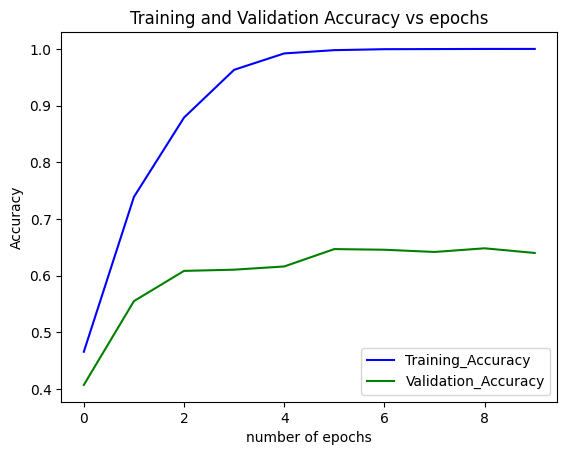

In [16]:
plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(valid_acc)), valid_acc, color = 'green')
plt.title("Training and Validation Accuracy vs epochs")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.legend(["Training_Accuracy", "Validation_Accuracy"])


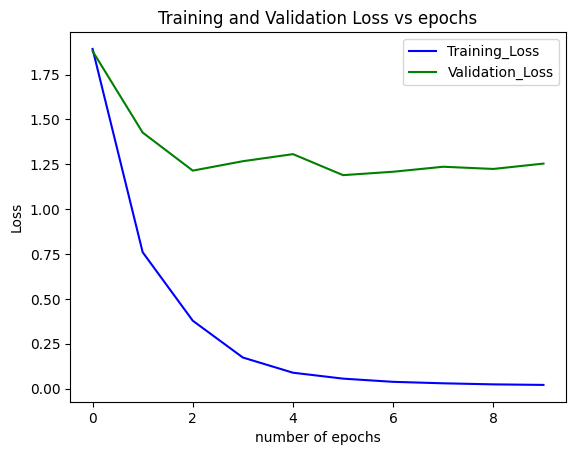

In [17]:
plt.plot(np.arange(len(train_loss)), train_loss, color = 'blue')
plt.plot(np.arange(len(valid_loss)), valid_loss, color = 'green')
plt.title("Training and Validation Loss vs epochs")
plt.xlabel("number of epochs")
plt.ylabel("Loss")
plt.legend(["Training_Loss", "Validation_Loss"])